# Gensim NMF vs other models

In [1]:
%load_ext line_profiler
%load_ext autoreload

%autoreload 2

from gensim.models.nmf import Nmf as GensimNmf
from gensim.models import CoherenceModel, LdaModel
from gensim.parsing.preprocessing import preprocess_documents
from gensim import matutils
from sklearn.decomposition.nmf import NMF as SklearnNmf
import sklearn.decomposition.nmf
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from matplotlib import pyplot as plt

import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# 20newsgroups

In [2]:
from gensim.parsing.preprocessing import preprocess_documents

documents = preprocess_documents(fetch_20newsgroups().data[:3000])

In [3]:
from gensim.corpora import Dictionary

dictionary = Dictionary(documents)

dictionary.filter_extremes()

2018-08-28 13:14:37,238 : INFO : adding document #0 to Dictionary(0 unique tokens: [])
2018-08-28 13:14:37,818 : INFO : built Dictionary(33228 unique tokens: ['addit', 'bodi', 'bricklin', 'brought', 'bumper']...) from 3000 documents (total 412672 corpus positions)
2018-08-28 13:14:37,895 : INFO : discarding 26411 tokens: [('bricklin', 3), ('edu', 1951), ('lerxst', 2), ('line', 2964), ('organ', 2871), ('post', 1535), ('rac', 2), ('subject', 3000), ('tellm', 2), ('attain', 4)]...
2018-08-28 13:14:37,897 : INFO : keeping 6817 tokens which were in no less than 5 and no more than 1500 (=50.0%) documents
2018-08-28 13:14:37,915 : INFO : resulting dictionary: Dictionary(6817 unique tokens: ['addit', 'bodi', 'brought', 'bumper', 'call']...)


In [4]:
corpus = [
    dictionary.doc2bow(document)
    for document
    in documents
]

bow_matrix = matutils.corpus2dense(corpus, len(dictionary), len(documents))
proba_bow_matrix = bow_matrix / bow_matrix.sum(axis=0)

## Sklearn NMF

In [5]:
%%time

sklearn_nmf = SklearnNmf(n_components=5, tol=1e-5, max_iter=int(1e9), random_state=42)

W = sklearn_nmf.fit_transform(proba_bow_matrix)
H = sklearn_nmf.components_

CPU times: user 33 s, sys: 7.22 s, total: 40.2 s
Wall time: 12.6 s


In [6]:
np.linalg.norm(proba_bow_matrix - W.dot(H), 'fro')

8.999726758761664

## Gensim NMF vs Gensim LDA

In [7]:
training_params = dict(
    corpus=corpus,
    chunksize=1000,
    num_topics=5,
    id2word=dictionary,
    passes=5,
    eval_every=10,
    minimum_probability=0
)

### Training time

In [8]:
%%time

np.random.seed(42)

gensim_nmf = GensimNmf(**training_params)

2018-08-28 13:14:55,779 : INFO : Loss (no outliers): 571.9953309314792	Loss (with outliers): 571.9953309314792
2018-08-28 13:14:58,619 : INFO : Loss (no outliers): 553.622398952605	Loss (with outliers): 553.622398952605
2018-08-28 13:15:00,841 : INFO : Loss (no outliers): 551.2262280048596	Loss (with outliers): 551.2262280048596
2018-08-28 13:15:01,947 : INFO : Loss (no outliers): 562.7352175359472	Loss (with outliers): 562.7352175359472
2018-08-28 13:15:03,665 : INFO : Loss (no outliers): 550.0473747816856	Loss (with outliers): 550.0473747816856
2018-08-28 13:15:05,927 : INFO : Loss (no outliers): 549.2175014887133	Loss (with outliers): 549.2175014887133


CPU times: user 18.6 s, sys: 18.8 s, total: 37.4 s
Wall time: 14 s


In [9]:
%%time

np.random.seed(42)

gensim_lda = LdaModel(**training_params)

2018-08-28 13:15:05,987 : INFO : using symmetric alpha at 0.2
2018-08-28 13:15:05,991 : INFO : using symmetric eta at 0.2
2018-08-28 13:15:05,997 : INFO : using serial LDA version on this node
2018-08-28 13:15:06,009 : INFO : running online (multi-pass) LDA training, 5 topics, 5 passes over the supplied corpus of 3000 documents, updating model once every 1000 documents, evaluating perplexity every 3000 documents, iterating 50x with a convergence threshold of 0.001000
2018-08-28 13:15:06,012 : INFO : PROGRESS: pass 0, at document #1000/3000
2018-08-28 13:15:07,053 : INFO : merging changes from 1000 documents into a model of 3000 documents
2018-08-28 13:15:07,062 : INFO : topic #0 (0.200): 0.016*"max" + 0.006*"com" + 0.006*"articl" + 0.005*"univers" + 0.005*"like" + 0.005*"good" + 0.004*"nntp" + 0.003*"think" + 0.003*"host" + 0.003*"know"
2018-08-28 13:15:07,063 : INFO : topic #1 (0.200): 0.010*"com" + 0.007*"articl" + 0.006*"know" + 0.006*"peopl" + 0.004*"univers" + 0.004*"like" + 0.004

2018-08-28 13:15:14,776 : INFO : topic diff=0.389880, rho=0.447214
2018-08-28 13:15:14,777 : INFO : PROGRESS: pass 2, at document #1000/3000
2018-08-28 13:15:15,539 : INFO : merging changes from 1000 documents into a model of 3000 documents
2018-08-28 13:15:15,545 : INFO : topic #0 (0.200): 0.013*"max" + 0.010*"window" + 0.007*"file" + 0.007*"us" + 0.006*"com" + 0.006*"kei" + 0.006*"program" + 0.005*"univers" + 0.005*"problem" + 0.004*"host"
2018-08-28 13:15:15,547 : INFO : topic #1 (0.200): 0.016*"com" + 0.008*"articl" + 0.007*"host" + 0.006*"nntp" + 0.006*"univers" + 0.005*"know" + 0.005*"us" + 0.005*"like" + 0.004*"work" + 0.004*"need"
2018-08-28 13:15:15,548 : INFO : topic #2 (0.200): 0.008*"god" + 0.007*"christian" + 0.006*"think" + 0.006*"game" + 0.006*"articl" + 0.005*"like" + 0.005*"univers" + 0.005*"know" + 0.005*"believ" + 0.005*"plai"
2018-08-28 13:15:15,550 : INFO : topic #3 (0.200): 0.013*"com" + 0.010*"articl" + 0.007*"like" + 0.006*"car" + 0.005*"host" + 0.005*"nntp" + 0

2018-08-28 13:15:22,503 : INFO : topic #1 (0.200): 0.017*"com" + 0.008*"articl" + 0.008*"host" + 0.008*"nntp" + 0.007*"univers" + 0.005*"know" + 0.005*"us" + 0.005*"like" + 0.005*"drive" + 0.004*"new"
2018-08-28 13:15:22,506 : INFO : topic #2 (0.200): 0.011*"god" + 0.008*"christian" + 0.007*"think" + 0.007*"game" + 0.006*"jesu" + 0.006*"articl" + 0.005*"believ" + 0.005*"know" + 0.005*"plai" + 0.005*"univers"
2018-08-28 13:15:22,508 : INFO : topic #3 (0.200): 0.014*"com" + 0.011*"articl" + 0.007*"like" + 0.006*"car" + 0.005*"host" + 0.005*"nntp" + 0.005*"think" + 0.005*"univers" + 0.005*"time" + 0.004*"peopl"
2018-08-28 13:15:22,509 : INFO : topic #4 (0.200): 0.010*"peopl" + 0.006*"armenian" + 0.005*"state" + 0.005*"govern" + 0.005*"right" + 0.004*"articl" + 0.004*"jew" + 0.004*"know" + 0.004*"think" + 0.004*"time"
2018-08-28 13:15:22,510 : INFO : topic diff=0.224455, rho=0.353553
2018-08-28 13:15:22,512 : INFO : PROGRESS: pass 4, at document #2000/3000
2018-08-28 13:15:23,236 : INFO : 

CPU times: user 18.8 s, sys: 158 ms, total: 19 s
Wall time: 19.1 s


### Coherence

In [10]:
gensim_nmf_cm = CoherenceModel(
    model=gensim_nmf,
    corpus=corpus,
    coherence='u_mass'
)

gensim_nmf_cm.get_coherence()

2018-08-28 13:15:29,891 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-08-28 13:15:29,927 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-08-28 13:15:29,964 : INFO : CorpusAccumulator accumulated stats from 3000 documents


-1.8015688322676469

In [11]:
gensim_lda_cm = CoherenceModel(
    model=gensim_lda,
    corpus=corpus,
    coherence='u_mass'
)

gensim_lda_cm.get_coherence()

2018-08-28 13:15:30,771 : INFO : CorpusAccumulator accumulated stats from 1000 documents
2018-08-28 13:15:30,800 : INFO : CorpusAccumulator accumulated stats from 2000 documents
2018-08-28 13:15:30,831 : INFO : CorpusAccumulator accumulated stats from 3000 documents


-1.7170102353622116

### Perplexity

In [12]:
def perplexity(model, corpus):
    W = gensim_nmf.get_topics().T

    H = np.zeros((W.shape[1], len(corpus)))
    for bow_id, bow in enumerate(corpus):
        for topic_id, proba in model[bow]:
            H[topic_id, bow_id] = proba
    
    dense_corpus = matutils.corpus2dense(corpus, W.shape[0])
    
    return np.exp(-(np.log(W.dot(H), where=W.dot(H)>0) * dense_corpus).sum() / dense_corpus.sum())

In [13]:
perplexity(gensim_nmf, corpus)

2563.118564220738

In [14]:
perplexity(gensim_lda, corpus)

10311.521089623771

In [15]:
gensim_nmf.show_topics()

[(0,
  '0.026*"anonym" + 0.020*"internet" + 0.015*"privaci" + 0.013*"us" + 0.013*"user" + 0.013*"email" + 0.012*"address" + 0.011*"file" + 0.011*"inform" + 0.011*"mail"'),
 (1,
  '0.024*"file" + 0.019*"program" + 0.014*"avail" + 0.013*"includ" + 0.012*"version" + 0.011*"output" + 0.009*"ftp" + 0.009*"sourc" + 0.009*"packag" + 0.008*"sun"'),
 (2,
  '0.014*"peopl" + 0.011*"armenian" + 0.010*"turkish" + 0.010*"jew" + 0.009*"said" + 0.008*"know" + 0.006*"dai" + 0.006*"turkei" + 0.005*"time" + 0.005*"think"'),
 (3,
  '0.775*"max" + 0.063*"giz" + 0.020*"wtm" + 0.006*"mei" + 0.006*"usd" + 0.006*"salmon" + 0.006*"pwiseman" + 0.006*"cliff" + 0.006*"ma" + 0.006*"end"'),
 (4,
  '0.009*"com" + 0.006*"articl" + 0.005*"space" + 0.005*"new" + 0.005*"like" + 0.005*"time" + 0.004*"good" + 0.004*"problem" + 0.004*"think" + 0.004*"univers"')]

In [16]:
gensim_lda.show_topics()

[(0,
  '0.012*"max" + 0.011*"window" + 0.009*"file" + 0.008*"us" + 0.007*"kei" + 0.007*"program" + 0.006*"com" + 0.005*"univers" + 0.004*"mail" + 0.004*"version"'),
 (1,
  '0.017*"com" + 0.008*"host" + 0.008*"nntp" + 0.008*"articl" + 0.007*"univers" + 0.006*"drive" + 0.005*"know" + 0.005*"card" + 0.005*"like" + 0.005*"us"'),
 (2,
  '0.012*"god" + 0.009*"christian" + 0.007*"game" + 0.007*"think" + 0.006*"articl" + 0.006*"plai" + 0.006*"believ" + 0.005*"know" + 0.005*"univers" + 0.005*"year"'),
 (3,
  '0.014*"com" + 0.011*"articl" + 0.007*"like" + 0.006*"car" + 0.006*"host" + 0.005*"nntp" + 0.005*"think" + 0.005*"univers" + 0.004*"time" + 0.004*"thing"'),
 (4,
  '0.011*"peopl" + 0.006*"govern" + 0.005*"right" + 0.005*"state" + 0.005*"armenian" + 0.005*"jew" + 0.004*"law" + 0.004*"think" + 0.004*"articl" + 0.004*"know"')]

In [ ]:
# W = gensim_nmf.get_topics().T
# H = np.hstack(np.array(gensim_nmf[bow])[:, 1:] for bow in corpus)

In [ ]:
# np.linalg.norm(proba_bow_matrix - W.dot(H), 'fro')

# Image of stars
### (For the sake of visualization of performance on sparse trainset)

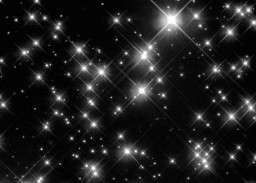

In [17]:
from PIL import Image
img = Image.open('stars_scaled.jpg').convert('L')
img

In [18]:
img_matrix = np.uint8(img.getdata()).reshape(img.size[::-1])
img_matrix.shape

(183, 256)

## Sklearn NMF

In [19]:
%%time

sklearn_nmf = SklearnNmf(n_components=10, tol=1e-5, max_iter=int(1e9))

W = sklearn_nmf.fit_transform(img_matrix)
H = sklearn_nmf.components_

CPU times: user 374 ms, sys: 560 ms, total: 934 ms
Wall time: 262 ms


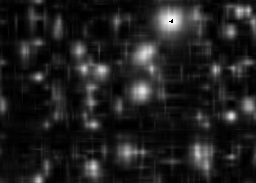

In [20]:
Image.fromarray(np.uint8(W.dot(H)), 'L')

## Gensim NMF

In [21]:
np.random.seed(42)

img_corpus = matutils.Dense2Corpus(img_matrix[np.random.choice(img_matrix.shape[0], img_matrix.shape[0], replace=False)].T)

In [22]:
%%time

import itertools

gensim_nmf = GensimNmf(
    img_corpus,
    chunksize=40,
    num_topics=10,
    passes=1,
    id2word={k: k for k in range(img_matrix.shape[1])},
    lambda_=1000,
    kappa=1,
    normalize=False
)

2018-08-20 22:15:22,726 : INFO : h_r_error: 17211892.5
2018-08-20 22:15:22,729 : INFO : h_r_error: 12284515.111163257
2018-08-20 22:15:22,731 : INFO : h_r_error: 11201387.638214733
2018-08-20 22:15:22,734 : INFO : h_r_error: 10815579.549704548
2018-08-20 22:15:22,738 : INFO : h_r_error: 10646539.06006998
2018-08-20 22:15:22,747 : INFO : h_r_error: 10558409.831047071
2018-08-20 22:15:22,755 : INFO : h_r_error: 10507775.272428757
2018-08-20 22:15:22,757 : INFO : h_r_error: 10475469.606854783
2018-08-20 22:15:22,759 : INFO : h_r_error: 10453925.335400445
2018-08-20 22:15:22,762 : INFO : h_r_error: 10439939.102116534
2018-08-20 22:15:22,784 : INFO : w_error: 10430366.610691467
2018-08-20 22:15:22,788 : INFO : w_error: 11466405.186009312
2018-08-20 22:15:22,791 : INFO : w_error: 10938537.274967317
2018-08-20 22:15:22,793 : INFO : w_error: 10835183.946454465
2018-08-20 22:15:22,799 : INFO : w_error: 10808896.588521175
2018-08-20 22:15:22,803 : INFO : w_error: 10800700.69189361
2018-08-20 22:

2018-08-20 22:15:23,774 : INFO : w_error: 2366899.5684030103
2018-08-20 22:15:23,780 : INFO : w_error: 2347964.180692087
2018-08-20 22:15:23,787 : INFO : w_error: 2332331.149509242
2018-08-20 22:15:23,791 : INFO : w_error: 2319290.024670701
2018-08-20 22:15:23,794 : INFO : w_error: 2308301.644607859
2018-08-20 22:15:23,811 : INFO : w_error: 2298998.176426708
2018-08-20 22:15:23,814 : INFO : w_error: 2291054.8383098356
2018-08-20 22:15:23,818 : INFO : w_error: 2284233.8267418565
2018-08-20 22:15:23,821 : INFO : w_error: 2278346.4815429775
2018-08-20 22:15:23,823 : INFO : w_error: 2273239.326070163
2018-08-20 22:15:23,824 : INFO : w_error: 2268800.1953844256
2018-08-20 22:15:23,826 : INFO : w_error: 2264918.837606525
2018-08-20 22:15:23,828 : INFO : w_error: 2261511.2618650706
2018-08-20 22:15:23,830 : INFO : w_error: 2258510.001427239
2018-08-20 22:15:23,831 : INFO : w_error: 2255858.510132532
2018-08-20 22:15:23,833 : INFO : w_error: 2253518.01968442
2018-08-20 22:15:23,834 : INFO : w_

CPU times: user 1.3 s, sys: 1.91 s, total: 3.22 s
Wall time: 1.63 s


In [23]:
W = gensim_nmf.get_topics().T
H = np.hstack(gensim_nmf[bow] for bow in matutils.Dense2Corpus(img_matrix.T))

2018-08-20 22:15:24,333 : INFO : h_r_error: 1641779.1711565189
2018-08-20 22:15:24,335 : INFO : h_r_error: 118028.68383364937
2018-08-20 22:15:24,337 : INFO : h_r_error: 105616.73503369163
2018-08-20 22:15:24,339 : INFO : h_r_error: 105376.48023111676
2018-08-20 22:15:24,344 : INFO : h_r_error: 105376.48023111676
2018-08-20 22:15:24,345 : INFO : h_r_error: 88296.81129174746
2018-08-20 22:15:24,347 : INFO : h_r_error: 75598.49700209008
2018-08-20 22:15:24,350 : INFO : h_r_error: 75202.00810070324
2018-08-20 22:15:24,352 : INFO : h_r_error: 75202.00810070324
2018-08-20 22:15:24,353 : INFO : h_r_error: 40896.39022296863
2018-08-20 22:15:24,354 : INFO : h_r_error: 32494.67090191547
2018-08-20 22:15:24,356 : INFO : h_r_error: 32239.868252556797
2018-08-20 22:15:24,366 : INFO : h_r_error: 32239.868252556797
2018-08-20 22:15:24,368 : INFO : h_r_error: 44930.159607806534
2018-08-20 22:15:24,370 : INFO : h_r_error: 36557.7492240496
2018-08-20 22:15:24,371 : INFO : h_r_error: 35312.9484972738
20

2018-08-20 22:15:24,658 : INFO : h_r_error: 134685.80489629053
2018-08-20 22:15:24,661 : INFO : h_r_error: 113538.95669792594
2018-08-20 22:15:24,665 : INFO : h_r_error: 113353.41144229252
2018-08-20 22:15:24,669 : INFO : h_r_error: 113353.41144229252
2018-08-20 22:15:24,671 : INFO : h_r_error: 122345.42442740352
2018-08-20 22:15:24,672 : INFO : h_r_error: 101206.04117840753
2018-08-20 22:15:24,673 : INFO : h_r_error: 100993.62587045786
2018-08-20 22:15:24,674 : INFO : h_r_error: 100993.62587045786
2018-08-20 22:15:24,676 : INFO : h_r_error: 116266.06525752878
2018-08-20 22:15:24,677 : INFO : h_r_error: 96812.1429100881
2018-08-20 22:15:24,683 : INFO : h_r_error: 96671.85729303533
2018-08-20 22:15:24,686 : INFO : h_r_error: 96671.85729303533
2018-08-20 22:15:24,687 : INFO : h_r_error: 124976.11247413699
2018-08-20 22:15:24,689 : INFO : h_r_error: 105696.72347766797
2018-08-20 22:15:24,690 : INFO : h_r_error: 105516.7395837665
2018-08-20 22:15:24,691 : INFO : h_r_error: 105516.739583766

2018-08-20 22:15:25,015 : INFO : h_r_error: 58344.200783367785
2018-08-20 22:15:25,020 : INFO : h_r_error: 56997.1979143896
2018-08-20 22:15:25,023 : INFO : h_r_error: 56864.86772938072
2018-08-20 22:15:25,025 : INFO : h_r_error: 56864.86772938072
2018-08-20 22:15:25,031 : INFO : h_r_error: 55804.84516396389
2018-08-20 22:15:25,032 : INFO : h_r_error: 49720.76312800324
2018-08-20 22:15:25,034 : INFO : h_r_error: 48669.3293093283
2018-08-20 22:15:25,036 : INFO : h_r_error: 48566.79973146436
2018-08-20 22:15:25,039 : INFO : h_r_error: 48566.79973146436
2018-08-20 22:15:25,042 : INFO : h_r_error: 50232.78247908833
2018-08-20 22:15:25,045 : INFO : h_r_error: 43460.18499959944
2018-08-20 22:15:25,047 : INFO : h_r_error: 42583.76639804095
2018-08-20 22:15:25,049 : INFO : h_r_error: 42583.76639804095
2018-08-20 22:15:25,051 : INFO : h_r_error: 70689.83802178742
2018-08-20 22:15:25,053 : INFO : h_r_error: 54799.329874802635
2018-08-20 22:15:25,057 : INFO : h_r_error: 53914.8316747843
2018-08-2

2018-08-20 22:15:25,356 : INFO : h_r_error: 123923.46378028487
2018-08-20 22:15:25,357 : INFO : h_r_error: 91401.7915719367
2018-08-20 22:15:25,359 : INFO : h_r_error: 85191.39582673303
2018-08-20 22:15:25,361 : INFO : h_r_error: 84532.90616743342
2018-08-20 22:15:25,364 : INFO : h_r_error: 84532.90616743342
2018-08-20 22:15:25,365 : INFO : h_r_error: 111957.92974291708
2018-08-20 22:15:25,367 : INFO : h_r_error: 90673.10717043538
2018-08-20 22:15:25,368 : INFO : h_r_error: 86795.48708018255
2018-08-20 22:15:25,370 : INFO : h_r_error: 86359.0193082306
2018-08-20 22:15:25,372 : INFO : h_r_error: 86359.0193082306
2018-08-20 22:15:25,374 : INFO : h_r_error: 78116.94232451699
2018-08-20 22:15:25,389 : INFO : h_r_error: 64864.185952766085
2018-08-20 22:15:25,403 : INFO : h_r_error: 62627.20138398043
2018-08-20 22:15:25,406 : INFO : h_r_error: 62387.88488623845
2018-08-20 22:15:25,417 : INFO : h_r_error: 62387.88488623845
2018-08-20 22:15:25,418 : INFO : h_r_error: 49500.7753928332
2018-08-2

2018-08-20 22:15:25,908 : INFO : h_r_error: 20608.810430887163
2018-08-20 22:15:25,910 : INFO : h_r_error: 20433.54257729559
2018-08-20 22:15:25,911 : INFO : h_r_error: 20400.741509122505
2018-08-20 22:15:25,913 : INFO : h_r_error: 20400.741509122505
2018-08-20 22:15:25,916 : INFO : h_r_error: 28200.31679054761
2018-08-20 22:15:25,919 : INFO : h_r_error: 23300.098733814248
2018-08-20 22:15:25,929 : INFO : h_r_error: 22137.1510942318
2018-08-20 22:15:25,931 : INFO : h_r_error: 21810.085864093246
2018-08-20 22:15:25,932 : INFO : h_r_error: 21775.213278946343
2018-08-20 22:15:25,934 : INFO : h_r_error: 21775.213278946343
2018-08-20 22:15:25,935 : INFO : h_r_error: 15260.366709589653
2018-08-20 22:15:25,936 : INFO : h_r_error: 11872.08315938859
2018-08-20 22:15:25,937 : INFO : h_r_error: 10908.905597899073
2018-08-20 22:15:25,938 : INFO : h_r_error: 10684.630020773682
2018-08-20 22:15:25,939 : INFO : h_r_error: 10651.271246929588
2018-08-20 22:15:25,941 : INFO : h_r_error: 10651.2712469295

2018-08-20 22:15:26,250 : INFO : h_r_error: 89193.15992567304
2018-08-20 22:15:26,251 : INFO : h_r_error: 82326.7193949022
2018-08-20 22:15:26,253 : INFO : h_r_error: 81654.10188430984
2018-08-20 22:15:26,254 : INFO : h_r_error: 81550.8364588384
2018-08-20 22:15:26,256 : INFO : h_r_error: 81550.8364588384
2018-08-20 22:15:26,258 : INFO : h_r_error: 195202.30314943343
2018-08-20 22:15:26,259 : INFO : h_r_error: 87377.33791727532
2018-08-20 22:15:26,261 : INFO : h_r_error: 80672.67496760779
2018-08-20 22:15:26,262 : INFO : h_r_error: 80479.76631168138
2018-08-20 22:15:26,268 : INFO : h_r_error: 80479.76631168138
2018-08-20 22:15:26,271 : INFO : h_r_error: 144824.23872960033
2018-08-20 22:15:26,272 : INFO : h_r_error: 55900.50694270172
2018-08-20 22:15:26,273 : INFO : h_r_error: 50456.945266342926
2018-08-20 22:15:26,275 : INFO : h_r_error: 50209.455574301464
2018-08-20 22:15:26,277 : INFO : h_r_error: 50209.455574301464
2018-08-20 22:15:26,278 : INFO : h_r_error: 120497.96569875091
2018-

2018-08-20 22:15:26,582 : INFO : h_r_error: 18959.722842143907
2018-08-20 22:15:26,583 : INFO : h_r_error: 83876.31226742358
2018-08-20 22:15:26,584 : INFO : h_r_error: 27066.441250717817
2018-08-20 22:15:26,586 : INFO : h_r_error: 23671.276967366928
2018-08-20 22:15:26,587 : INFO : h_r_error: 23588.035853516478
2018-08-20 22:15:26,590 : INFO : h_r_error: 23588.035853516478
2018-08-20 22:15:26,591 : INFO : h_r_error: 87851.09522030315
2018-08-20 22:15:26,593 : INFO : h_r_error: 36557.55519906569
2018-08-20 22:15:26,596 : INFO : h_r_error: 32920.158554937225
2018-08-20 22:15:26,605 : INFO : h_r_error: 32884.0633641823


### Reconstructed matrix:

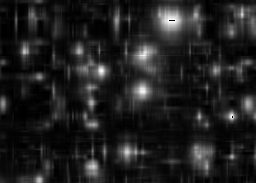

In [24]:
Image.fromarray(np.uint8(W.dot(H).T), 'L')